# Series de Tiempo
## Ejemplos con IBM & Walmart 
Katlyn Goeujon-Mackness <br>
28-04-2025

Considera la información histórica diaria de precios para las empresas IBM y Walmart contenida en el sitio de Yahoo finance (http://finance.yahoo.com) durante los últimos 5 años. 

In [70]:
# Cargar librerías 
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_squared_error

In [71]:
ibm = yf.download(tickers='ibm', period = '5y', interval = '1d', rounding=True)

[*********************100%***********************]  1 of 1 completed


In [72]:
ibm = ibm['Close']
ibm

Ticker,IBM
Date,
2020-04-29,97.87
2020-04-30,95.48
2020-05-01,92.68
2020-05-04,92.53
2020-05-05,93.22
...,...
2025-04-23,245.48
2025-04-24,229.33
2025-04-25,232.41


In [73]:
wmt = yf.download(tickers='wmt', period = '5y', interval = '1d', rounding=True)

[*********************100%***********************]  1 of 1 completed


In [74]:
wmt = wmt['Close']
wmt

Ticker,WMT
Date,
2020-04-29,38.29
2020-04-30,37.65
2020-05-01,38.08
2020-05-04,38.32
2020-05-05,38.64
...,...
2025-04-23,94.96
2025-04-24,95.84
2025-04-25,95.09


**¿Existe alguna correlación entre los precios de las acciones de ambas empresas?**
 Explica tanto de forma gráfica como a través del índice de correlación.

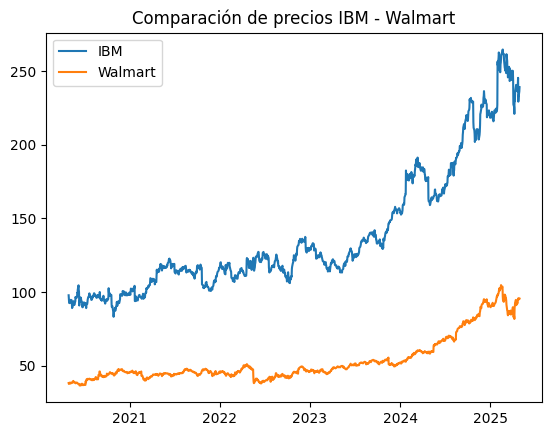

In [75]:
# Comparar los tickers 
plt.figure()
plt.plot(ibm, label="IBM")
plt.plot(wmt, label="Walmart")
plt.title('Comparación de precios IBM - Walmart')
plt.legend()
plt.show()

In [76]:
ibm_wmt = yf.download(tickers='ibm wmt', period = '5y', interval = '1d', rounding=True)
ibm_wmt = ibm_wmt['Close']

[*********************100%***********************]  2 of 2 completed


In [77]:
rend_ibm_wmt = ibm_wmt.pct_change()
rend_ibm_wmt

Ticker,IBM,WMT
Date,,
2020-04-29,NaN,NaN
2020-04-30,-0.024420,-0.016715
2020-05-01,-0.029326,0.011421
2020-05-04,-0.001618,0.006303
2020-05-05,0.007457,0.008351
...,...,...
2025-04-23,0.019012,0.001160
2025-04-24,-0.065789,0.009267
2025-04-25,0.013430,-0.007826


In [78]:
rend_ibm_wmt.dropna(inplace=True)
rend_ibm_wmt

Ticker,IBM,WMT
Date,,
2020-04-30,-0.024420,-0.016715
2020-05-01,-0.029326,0.011421
2020-05-04,-0.001618,0.006303
2020-05-05,0.007457,0.008351
2020-05-06,0.004827,-0.011646
...,...,...
2025-04-23,0.019012,0.001160
2025-04-24,-0.065789,0.009267
2025-04-25,0.013430,-0.007826


In [79]:
correlacion = rend_ibm_wmt['IBM'].corr(rend_ibm_wmt['WMT'])
print("Correlación entre IBM y Walmart:", correlacion)

Correlación entre IBM y Walmart: 0.20944132591195608


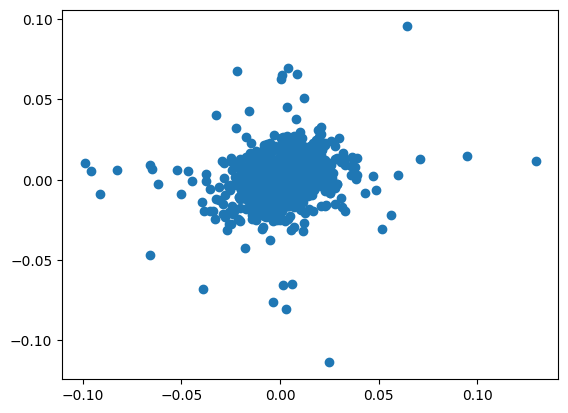

In [80]:
plt.scatter(rend_ibm_wmt['IBM'], rend_ibm_wmt['WMT'])
plt.show()

Comentarios: No hay correlación entre IBM and Walmart para este período

In [81]:
# Ajuste el modelo de regresión
rend_ibm_wmt = sm.add_constant(rend_ibm_wmt)
rend_ibm_wmt = rend_ibm_wmt.dropna()

regresion = sm.OLS(rend_ibm_wmt['IBM'], rend_ibm_wmt[['const', 'WMT']]).fit()

# Imprimir el resumen
print(regresion.summary())

                            OLS Regression Results                            
Dep. Variable:                    IBM   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     57.53
Date:                Tue, 29 Apr 2025   Prob (F-statistic):           6.45e-14
Time:                        15:01:38   Log-Likelihood:                 3501.7
No. Observations:                1256   AIC:                            -6999.
Df Residuals:                    1254   BIC:                            -6989.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      1.497      0.1

Comentario: El valor bajo de R-cuadrado sugiere una relación débil entre IBM y WMT. No existe autocorrelación significativa entre los dos. Los valores p y F sugierien un modelo significativo sobretodo.

### Autocorrelación

In [82]:
# Cálculo del índice de autocorelación
autocorr_ibm = ibm['IBM'].autocorr()
print("Autocorrelación de IBM:", autocorr_ibm)

autocorr_wmt = wmt['WMT'].autocorr()
print("Autocorrelación de WMT:", autocorr_wmt)

Autocorrelación de IBM: 0.9985261303860405
Autocorrelación de WMT: 0.998734686091404


Comentario: Los índices de autocorrelación son altos, lo que sugiere no estationaridad. Se usará la prueba Dickey-Fuller para confirmar la estionaridad y gráficos ACF para analizar patrones.

In [83]:
# Prueba Dickey-Fuller para los precios de IBM
resultado = adfuller(ibm)
print("El valor p de la prueba es:" + str(resultado[1]))

El valor p de la prueba es:0.9733368862513833


In [84]:
# Prueba Dickey-Fuller para los precios de WMT
resultado = adfuller(wmt)
print("El valor p de la prueba es:" + str(resultado[1]))

El valor p de la prueba es:0.9949273029773618


Comentario: Un valor p tan alto sugiere no estacionaridad.

In [85]:
rend_ibm = ibm.pct_change()
rend_ibm = rend_ibm.dropna()
rend_ibm

Ticker,IBM
Date,
2020-04-30,-0.024420
2020-05-01,-0.029326
2020-05-04,-0.001618
2020-05-05,0.007457
2020-05-06,0.004827
...,...
2025-04-23,0.019012
2025-04-24,-0.065789
2025-04-25,0.013430


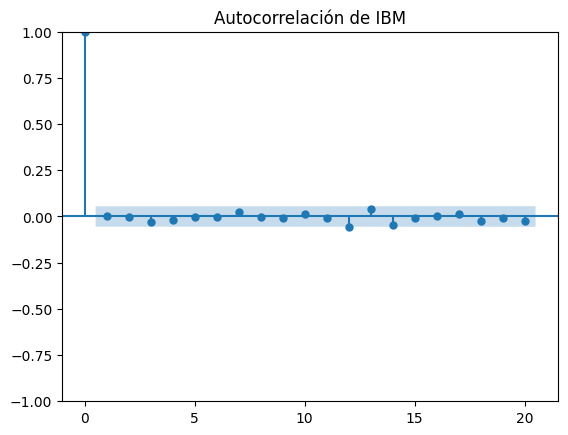

In [86]:
rendimientos = rend_ibm['IBM']
plot_acf(rendimientos, alpha=0.05, lags=20)
plt.title("Autocorrelación de IBM")
plt.show()

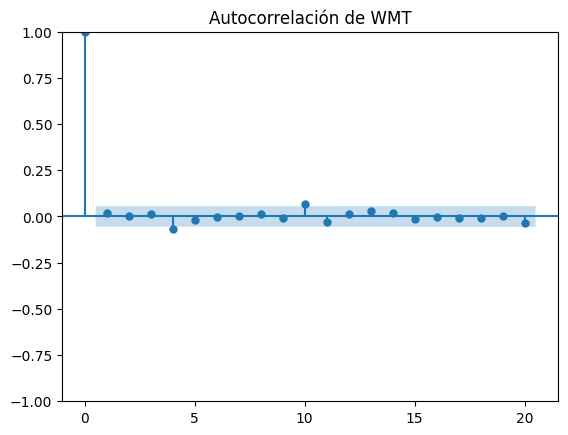

In [87]:
rend_wmt = wmt.pct_change()
rend_wmt = rend_wmt.dropna()

rendimientos = rend_wmt['WMT']
plot_acf(rendimientos, alpha=0.05, lags=20)
plt.title("Autocorrelación de WMT")
plt.show()

In [88]:
# Autocorrelaciones de las diferencias
ibm_diff = ibm.diff()
autocorr_ibm_diff = ibm_diff['IBM'].autocorr()
print("Autocorrelación de IBM:", autocorr_ibm_diff)

wmt_diff = wmt.diff()
autocorr_wmt_diff = wmt_diff['WMT'].autocorr()
print("Autocorrelación de WMT:", autocorr_wmt_diff)

Autocorrelación de IBM: -0.013250816058901223
Autocorrelación de WMT: 0.02170532480755058


Comentario: Las diferencias más cerca de 0 indican menos estacionaridad.

### Descomposición
#### IBM

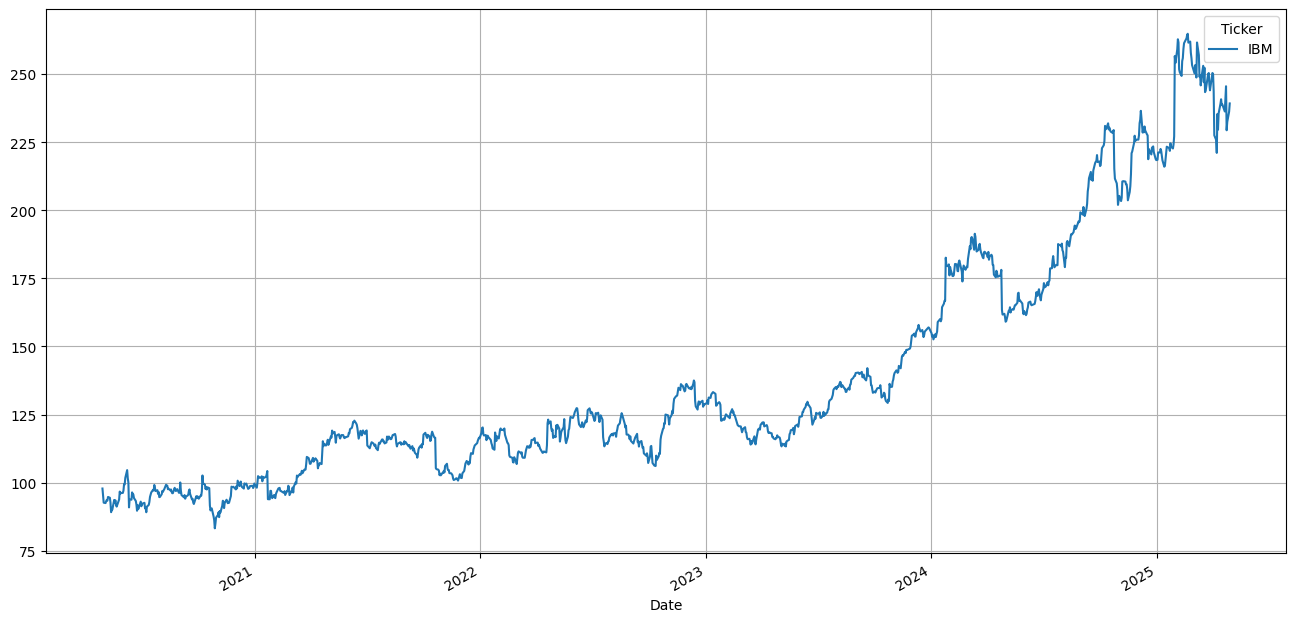

In [89]:
ibm.plot(figsize=(16,8)).grid()

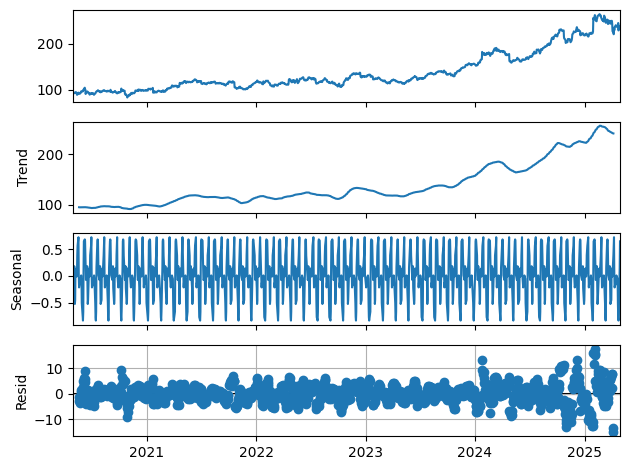

In [90]:
decomposed_ibm = sm.tsa.seasonal_decompose(ibm, period=30)
figure = decomposed_ibm.plot()
plt.grid()
plt.show()

#### WMT

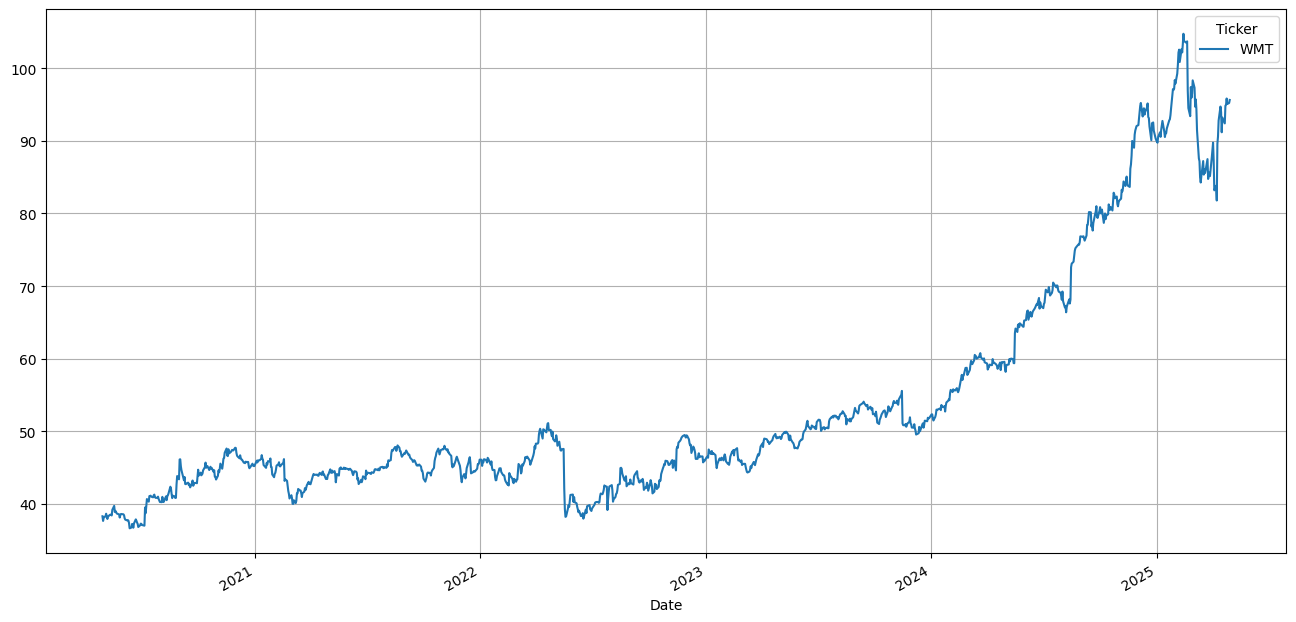

In [91]:
wmt.plot(figsize=(16,8)).grid()

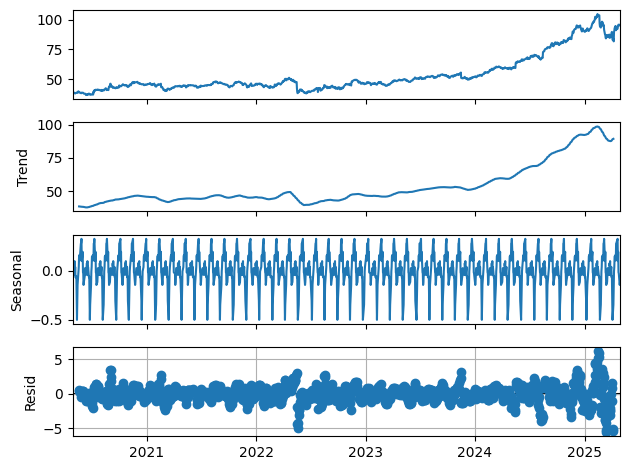

In [92]:
decomposed_wmt = sm.tsa.seasonal_decompose(wmt, period=30)
figure = decomposed_wmt.plot()
plt.grid()
plt.show()

### Promedios Móviles

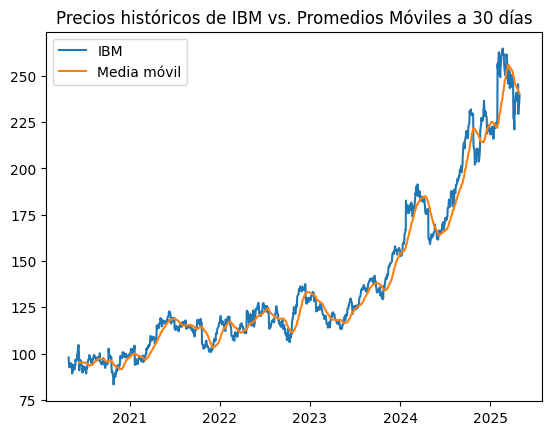

In [93]:
# Graficación de la media móvil para IBM
rolling_ibm = ibm.rolling(30).mean()

plt.figure()
plt.plot(ibm, label="IBM")
plt.plot(rolling_ibm, label='Media móvil')
plt.title("Precios históricos de IBM vs. Promedios Móviles a 30 días")
plt.legend()
plt.show()

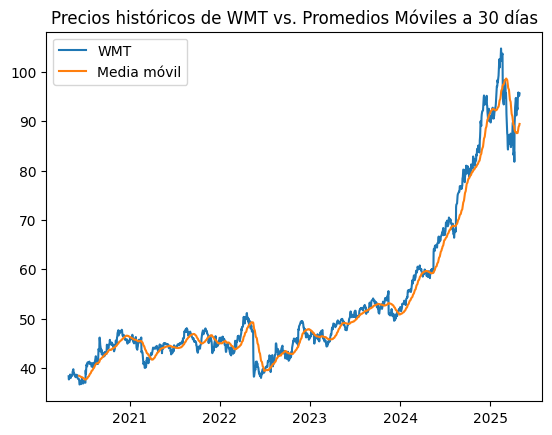

In [94]:
# Graficación de la media móvil para WMT
rolling_wmt = wmt.rolling(30).mean()

plt.figure()
plt.plot(wmt, label="WMT")
plt.plot(rolling_wmt, label='Media móvil')
plt.title("Precios históricos de WMT vs. Promedios Móviles a 30 días")
plt.legend()
plt.show()

### Pronóstico
Predicción simple mediante promedios móviles

#### IBM

In [95]:
ibm.shape

(1257, 1)

In [123]:
len_train = int(1258 * 0.8)


In [124]:
# Definición de grupos de entrenamiento y prueba
train = ibm[0:len_train]
test = ibm[len_train:]

In [125]:
len(train)

1006

In [126]:
y_pred = ibm.copy()
y_pred = pd.DataFrame(y_pred)

In [127]:
y_pred['pronostico'] = ibm.rolling(30).mean()
y_pred.tail()

Ticker,IBM,pronostico
Date,,
2025-04-23,245.48,242.297333
2025-04-24,229.33,241.620667
2025-04-25,232.41,241.174333
2025-04-28,236.16,240.768000
2025-04-29,239.17,240.308000


In [128]:
y_pred_m = y_pred.copy()
y_pred_m['pronostico'][29] = 'NaN'
for contador in range(30, len(y_pred_m)):
    y_pred_m['pronostico'][contador] = y_pred['pronostico'][contador - 1]

In [129]:
y_pred_m = pd.DataFrame(y_pred_m['pronostico'][1006:])
y_pred_m

,pronostico
Date,
2024-04-29,180.182
2024-04-30,179.419667
2024-05-01,178.597667
2024-05-02,177.665333
2024-05-03,176.721333
...,...
2025-04-23,242.413
2025-04-24,242.297333
2025-04-25,241.620667


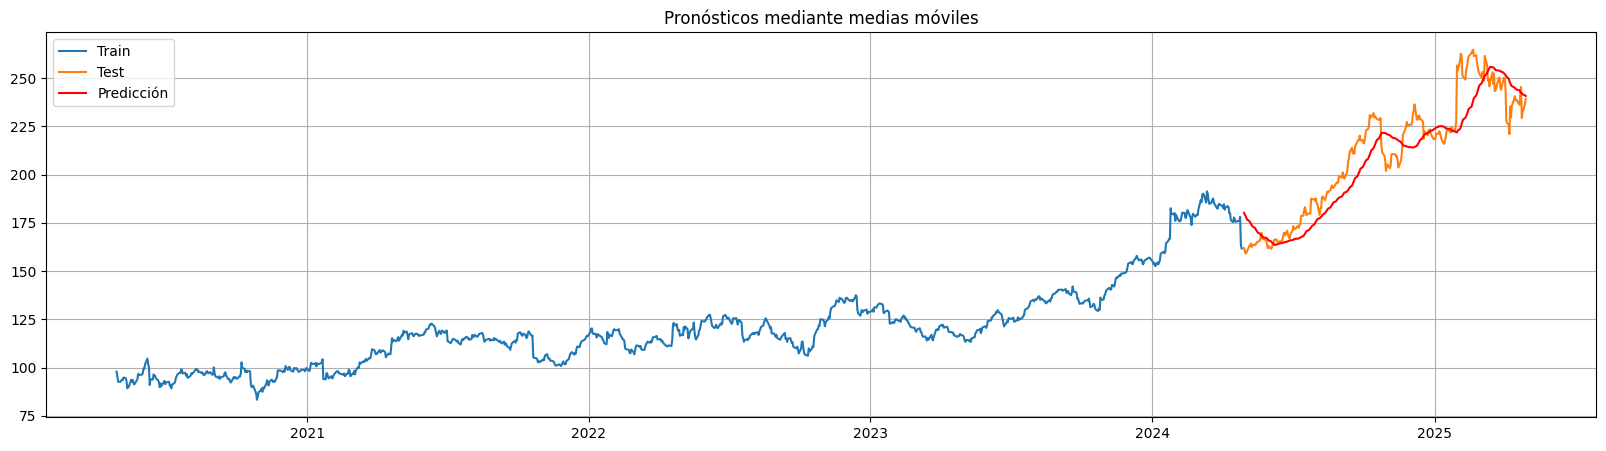

In [130]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(y_pred_m['pronostico'], label="Predicción", color='red')
plt.legend(loc='best')
plt.title("Pronósticos mediante medias móviles")
plt.show()

##### Evaluación

In [131]:
test = pd.DataFrame(test)
frames = [test, y_pred_m['pronostico']]  
result = pd.concat(frames, axis=1, join='inner')
result.columns = ['Observado', 'Pronosticado'] 
result

,Observado,Pronosticado
Date,,
2024-04-29,161.98,180.182
2024-04-30,160.79,179.419667
2024-05-01,159.08,178.597667
2024-05-02,159.33,177.665333
2024-05-03,160.32,176.721333
...,...,...
2025-04-23,245.48,242.413
2025-04-24,229.33,242.297333
2025-04-25,232.41,241.620667


In [132]:
test.shape

(251, 1)

In [133]:
y_pred_m

,pronostico
Date,
2024-04-29,180.182
2024-04-30,179.419667
2024-05-01,178.597667
2024-05-02,177.665333
2024-05-03,176.721333
...,...
2025-04-23,242.413
2025-04-24,242.297333
2025-04-25,241.620667


In [134]:
rmse = np.sqrt(mean_squared_error(test, y_pred_m)).round(2)
mape = np.round(np.mean(np.abs((test['IBM'] - y_pred_m['pronostico']) / test['IBM'])) * 100, 2)
print("RMSE =", rmse, "\nMAPE =", mape)

RMSE = 12.37 
MAPE = 4.67


Comentario: Con el MAPE bajo de 10%, el modelo funciona razonablemente bien.

In [135]:
# Pronóstico para el sigiuente día
y_pred.tail(1)['pronostico']

Date
2025-04-29    240.308
Name: pronostico, dtype: float64

#### Pronóstico WMT

In [137]:
wmt.shape

(1257, 1)

In [138]:
len_train = int(1258 * 0.8)


In [139]:
# Definición de grupos de entrenamiento y prueba
train = wmt[0:len_train]
test = wmt[len_train:]

In [140]:
y_pred = wmt.copy()
y_pred = pd.DataFrame(y_pred)

In [141]:
y_pred['pronostico'] = wmt.rolling(30).mean()
y_pred.tail()

Ticker,WMT,pronostico
Date,,
2025-04-23,94.96,88.120333
2025-04-24,95.84,88.482667
2025-04-25,95.09,88.843333
2025-04-28,95.22,89.180000
2025-04-29,95.64,89.460667


In [142]:
y_pred_m = y_pred.copy()
y_pred_m['pronostico'][29] = 'NaN'
for contador in range(30, len(y_pred_m)):
    y_pred_m['pronostico'][contador] = y_pred['pronostico'][contador - 1]

In [143]:
y_pred_m = pd.DataFrame(y_pred_m['pronostico'][1006:])

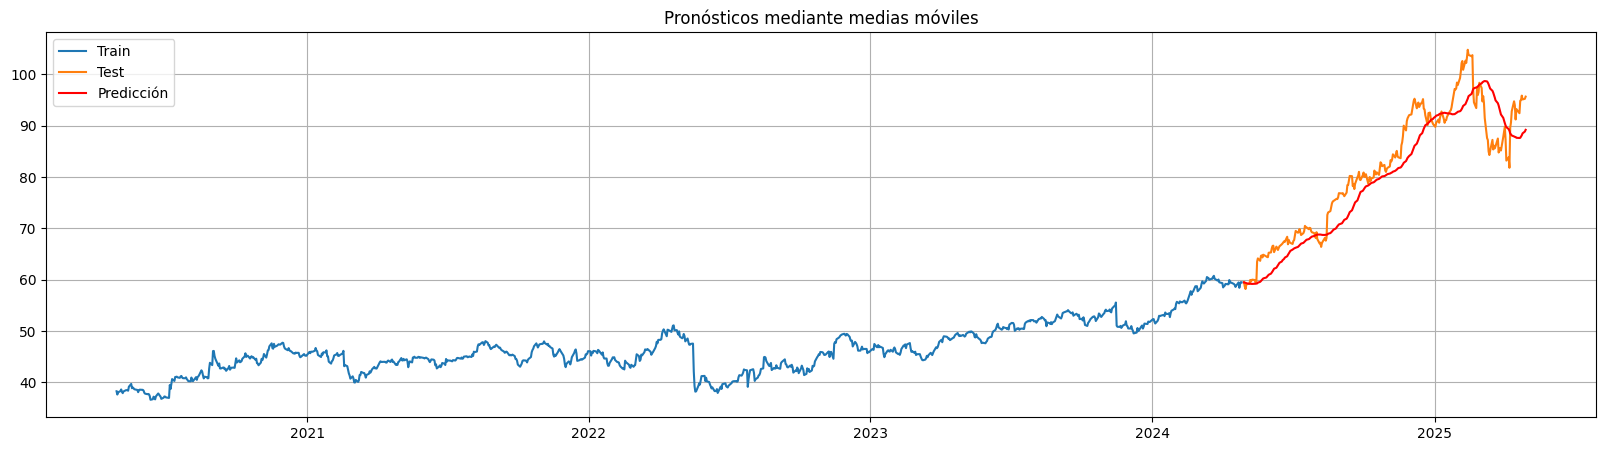

In [144]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(y_pred_m['pronostico'], label="Predicción", color='red')
plt.legend(loc='best')
plt.title("Pronósticos mediante medias móviles")
plt.show()

##### Evaluación

In [145]:
test = pd.DataFrame(test)
frames = [test, y_pred_m['pronostico']]  
result = pd.concat(frames, axis=1, join='inner')
result.columns = ['Observado', 'Pronosticado'] 
result

,Observado,Pronosticado
Date,,
2024-04-29,59.57,59.46
2024-04-30,58.69,59.445667
2024-05-01,58.19,59.396
2024-05-02,59.04,59.329333
2024-05-03,59.15,59.278667
...,...,...
2025-04-23,94.96,87.861667
2025-04-24,95.84,88.120333
2025-04-25,95.09,88.482667


In [147]:
rmse = np.sqrt(mean_squared_error(test, y_pred_m)).round(2)
mape = np.round(np.mean(np.abs((test['WMT'] - y_pred_m['pronostico']) / test['WMT'])) * 100, 2)
print("RMSE =", rmse, "\nMAPE =", mape)

RMSE = 4.79 
MAPE = 4.66


Comentario: Con el MAPE bajo de 10%, el modelo funciona razonablemente bien.

In [148]:
# Pronóstico para el sigiuente día
y_pred.tail(1)['pronostico']

Date
2025-04-29    89.460667
Name: pronostico, dtype: float64